# MODNet 'matbench_dielectric' benchmarking

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = ""


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



## Data exploration

In [2]:
df = load_dataset("matbench_dielectric")

In [3]:
from matminer.datasets import get_all_dataset_info

# Get dataset info from matminer
info = get_all_dataset_info("matbench_dielectric")

# Check out the info about the dataset.
print(info)

Dataset: matbench_dielectric
Description: Matbench v0.1 test dataset for predicting refractive index from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those having refractive indices less than 1 and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	n: Target variable. Refractive index (unitless).
	structure: Pymatgen Structure of the material.
Num Entries: 4764
Reference: Petousis, I., Mrdjenovich, D., Ballouz, E., Liu, M., Winston, D.,
Chen, W., Graf, T., Schladt, T. D., Persson, K. A. & Prinz, F. B.
High-throughput screening of inorganic compounds for the discovery
of novel dielectric and optical materials. Sci. Data 4, 160134 (2017).
Bibtex citations: ["@Article{Dunn2020,\nauthor={Dunn, Alexan

In [4]:
df.columns

Index(['structure', 'n'], dtype='object')

### Target space

In [5]:
df.describe()

,n
count,4764.000000
mean,2.428314
std,2.101722
min,1.000000
25%,1.684573
50%,2.060778
75%,2.595320
max,62.062998


Text(0.5, 0, 'n')

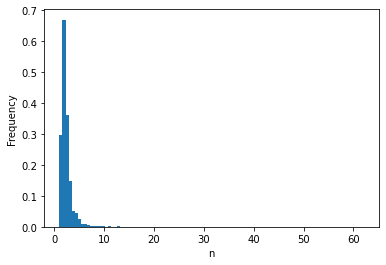

In [6]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["n"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("n")

## Featurization and feature selection

In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
PRECOMPUTED_MODDATA = "./precomputed/dielectric_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_dielectric")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["n"].tolist(), 
        target_names=["n"],
        featurizer=DeBreuck2020Featurizer()
    )
    data.featurize()
    data.save(PRECOMPUTED_MODDATA)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0f5d1c6340> object, created with modnet version 0.1.8~develop


## Training

In [6]:
from modnet.matbench.benchmark import matbench_benchmark


best_settings = {
    "increase_bs": False,
    "num_neurons": [[128], [32], [8], [8]],
    "n_feat": 512,
    "lr": 0.005,
    "epochs": 1000,
    "verbose": 0,
    "act": "relu",
    "batch_size": 64,
    "loss": "mae",
}

results = matbench_benchmark(data, [[["n"]]], {"n": 1}, best_settings, save_folds=False)
np.mean(results['scores'])

INFO:root:Loading cross NMI from 'Features_cross' file.


INFO:root:Starting target 1/1: n ...
INFO:root:Computing mutual information between features and target...
INFO:root:Computing optimal features...
INFO:root:Selected 50/1095 features...
INFO:root:Selected 100/1095 features...
INFO:root:Selected 150/1095 features...
INFO:root:Selected 200/1095 features...
INFO:root:Selected 250/1095 features...
INFO:root:Selected 300/1095 features...
INFO:root:Selected 350/1095 features...
INFO:root:Selected 400/1095 features...
INFO:root:Selected 450/1095 features...
INFO:root:Selected 500/1095 features...
INFO:root:Selected 550/1095 features...
INFO:root:Selected 600/1095 features...
INFO:root:Selected 650/1095 features...
INFO:root:Selected 700/1095 features...
INFO:root:Selected 750/1095 features...
INFO:root:Selected 800/1095 features...
INFO:root:Selected 850/1095 features...
INFO:root:Selected 900/1095 features...
INFO:root:Selected 950/1095 features...
INFO:root:Selected 1000/1095 features...
INFO:root:Selected 1050/1095 features...
INFO:root:Do

INFO:root:Starting target 1/1: n ...
INFO:root:Computing mutual information between features and target...


Model #1: MAE = 0.2509503633533743


INFO:root:Computing optimal features...
INFO:root:Selected 50/1093 features...
INFO:root:Selected 100/1093 features...
INFO:root:Selected 150/1093 features...
INFO:root:Selected 200/1093 features...
INFO:root:Selected 250/1093 features...
INFO:root:Selected 300/1093 features...
INFO:root:Selected 350/1093 features...
INFO:root:Selected 400/1093 features...
INFO:root:Selected 450/1093 features...
INFO:root:Selected 500/1093 features...
INFO:root:Selected 550/1093 features...
INFO:root:Selected 600/1093 features...
INFO:root:Selected 650/1093 features...
INFO:root:Selected 700/1093 features...
INFO:root:Selected 750/1093 features...
INFO:root:Selected 800/1093 features...
INFO:root:Selected 850/1093 features...
INFO:root:Selected 900/1093 features...
INFO:root:Selected 950/1093 features...
INFO:root:Selected 1000/1093 features...
INFO:root:Selected 1050/1093 features...
INFO:root:Done with target 1/1: n.
INFO:root:Merging all features...
INFO:root:Done.
INFO:root:Data successfully saved 

INFO:root:Starting target 1/1: n ...
INFO:root:Computing mutual information between features and target...


Model #2: MAE = 0.2869717523084029


INFO:root:Computing optimal features...
INFO:root:Selected 50/1092 features...
INFO:root:Selected 100/1092 features...
INFO:root:Selected 150/1092 features...
INFO:root:Selected 200/1092 features...
INFO:root:Selected 250/1092 features...
INFO:root:Selected 300/1092 features...
INFO:root:Selected 350/1092 features...
INFO:root:Selected 400/1092 features...
INFO:root:Selected 450/1092 features...
INFO:root:Selected 500/1092 features...
INFO:root:Selected 550/1092 features...
INFO:root:Selected 600/1092 features...
INFO:root:Selected 650/1092 features...
INFO:root:Selected 700/1092 features...
INFO:root:Selected 750/1092 features...
INFO:root:Selected 800/1092 features...
INFO:root:Selected 850/1092 features...
INFO:root:Selected 900/1092 features...
INFO:root:Selected 950/1092 features...
INFO:root:Selected 1000/1092 features...
INFO:root:Selected 1050/1092 features...
INFO:root:Done with target 1/1: n.
INFO:root:Merging all features...
INFO:root:Done.
INFO:root:Data successfully saved 

INFO:root:Starting target 1/1: n ...
INFO:root:Computing mutual information between features and target...


Model #3: MAE = 0.4063867445488606


INFO:root:Computing optimal features...
INFO:root:Selected 50/1093 features...
INFO:root:Selected 100/1093 features...
INFO:root:Selected 150/1093 features...
INFO:root:Selected 200/1093 features...
INFO:root:Selected 250/1093 features...
INFO:root:Selected 300/1093 features...
INFO:root:Selected 350/1093 features...
INFO:root:Selected 400/1093 features...
INFO:root:Selected 450/1093 features...
INFO:root:Selected 500/1093 features...
INFO:root:Selected 550/1093 features...
INFO:root:Selected 600/1093 features...
INFO:root:Selected 650/1093 features...
INFO:root:Selected 700/1093 features...
INFO:root:Selected 750/1093 features...
INFO:root:Selected 800/1093 features...
INFO:root:Selected 850/1093 features...
INFO:root:Selected 900/1093 features...
INFO:root:Selected 950/1093 features...
INFO:root:Selected 1000/1093 features...
INFO:root:Selected 1050/1093 features...
INFO:root:Done with target 1/1: n.
INFO:root:Merging all features...
INFO:root:Done.
INFO:root:Data successfully saved 

INFO:root:Starting target 1/1: n ...
INFO:root:Computing mutual information between features and target...


Model #4: MAE = 0.7456656691150297


INFO:root:Computing optimal features...
INFO:root:Selected 50/1094 features...
INFO:root:Selected 100/1094 features...
INFO:root:Selected 150/1094 features...
INFO:root:Selected 200/1094 features...
INFO:root:Selected 250/1094 features...
INFO:root:Selected 300/1094 features...
INFO:root:Selected 350/1094 features...
INFO:root:Selected 400/1094 features...
INFO:root:Selected 450/1094 features...
INFO:root:Selected 500/1094 features...
INFO:root:Selected 550/1094 features...
INFO:root:Selected 600/1094 features...
INFO:root:Selected 650/1094 features...
INFO:root:Selected 700/1094 features...
INFO:root:Selected 750/1094 features...
INFO:root:Selected 800/1094 features...
INFO:root:Selected 850/1094 features...
INFO:root:Selected 900/1094 features...
INFO:root:Selected 950/1094 features...
INFO:root:Selected 1000/1094 features...
INFO:root:Selected 1050/1094 features...
INFO:root:Done with target 1/1: n.
INFO:root:Merging all features...
INFO:root:Done.
INFO:root:Data successfully saved 

Model #5: MAE = 0.35777242967964484


0.40954939180106253

In [7]:
from modnet.matbench.benchmark import matbench_benchmark

presets = [
    {
    "increase_bs": False,
    "num_neurons": [[128], [32], [8], [8]],
    "n_feat": 512,
    "lr": 0.005,
    "epochs": 1000,
    "verbose": 0,
    "act": "relu",
    "batch_size": 64,
    "loss": "mae"
    }
]

results = matbench_benchmark(data, [[["n"]]], {"n": 1}, best_settings, save_folds=False, presets=presets)
np.mean(results['scores'])

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0c100aac70> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f1!
INFO:root:Training preset #1/1: {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.498
INFO:root:Preset #1 resulted in lowest validation loss with params {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
Fitting all data...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: MAE = 0.20130573227157933


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0ad42c46a0> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f2!
INFO:root:Training preset #1/1: {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.459
INFO:root:Preset #1 resulted in lowest validation loss with params {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
Fitting all data...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: MAE = 0.2819788511258654


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0ab86b8040> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f3!
INFO:root:Training preset #1/1: {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.384
INFO:root:Preset #1 resulted in lowest validation loss with params {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
Fitting all data...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: MAE = 0.43052866655251987


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0f5e5ccc40> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f4!
INFO:root:Training preset #1/1: {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.391
INFO:root:Preset #1 resulted in lowest validation loss with params {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
Fitting all data...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: MAE = 0.3200698541982597


INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0bd024db50> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f5!
INFO:root:Training preset #1/1: {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.495
INFO:root:Preset #1 resulted in lowest validation loss with params {'increase_bs': False, 'num_neurons': [[128], [32], [8], [8]], 'n_feat': 512, 'lr': 0.005, 'epochs': 1000, 'verbose': 0, 'act': 'relu', 'batch_size': 64, 'loss': 'mae'}
Fitting all data...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #5: MAE = 0.33507076369185596


0.31379077356801605

In [9]:
for i in range(5):
    plt.plot(results["models"][i].history.history["loss"][50:])

KeyError: 'val_loss'

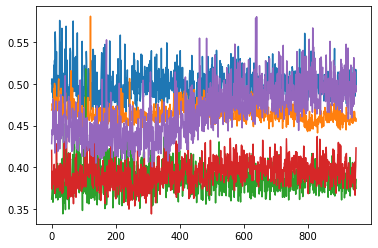

In [10]:
for i in range(5):
    plt.plot(results["all_nested_models"][i][0].history.history["val_loss"][50:])

In [35]:
def plot_benchmark(results):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    predictions = results["predictions"]
    targets = results["targets"]
    errors = [np.abs(p.values - t.values) for p, t in zip(predictions, targets)]
    
    fig, axes = plt.subplots(ncols=3, facecolor="w", figsize=(12, 4))
    ax = axes[0]
    for i in range(5):
        ax.hist(errors[i], bins=100)
    # name = model.target_names[0].split()[:-1]
    # units = model.target_names[0].split()[-1].replace(")", "").replace("(", "")
    # ax.set_ylabel("Frequency")
    # ax.set_xlabel(f"Absolute error")
    # ax.axvline(np.mean(model.history.history["val_mae"]), 0, 1, ls='--', color='r', label="Validation MAE")
    # ax.axvline(np.mean(errors), ls='--', color='b', label="Test MAE")
    # ax.legend()
    ax.set_xlim(0, 10)
    
    ax = axes[1]
    for i in range(5):
        t = targets[i]
        p = predictions[i]
        ax.scatter(t.values, p.values, alpha=0.25, label=f"Test MAE: {np.mean(errors[i]):3.3f}", s=5)
        ax.plot(np.linspace(*ax.get_xlim(), 2), np.linspace(*ax.get_xlim(), 2))
        
    # sns.regplot(x=data.df_targets.values, y=predictions.values, ax=ax)
    # ax.set_xlabel(f"{name} true ({units})")
    # ax.set_xlabel(f"{name} pred.({units})")
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    
   # ax = axes[2]
   # ax.plot(model.history.history["val_mae"][10:])
   # if target_mae is not None:
   #     ax.axhline(target_mae, ls='--', color="k", label="Automatminer RF")
   # ax.set_xlabel("Epoch")
   # ax.set_ylabel(f"Validation MAE ({units})")
   # plt.show(block=False)

    return predictions, errors

In [50]:
from modnet.matbench.benchmark import matbench_kfold_splits
for ind, (train, test) in enumerate(matbench_kfold_splits(data)):
    train_data, test_data = data.split((train, test))

{'models': [<modnet.models.MODNetModel at 0x7f0ed43ccf40>,
 'predictions': [               n
  id7     1.959398
  id9     2.025127
  id18    3.773492
  id24    3.834546
  id30    2.401092
  ...          ...
  id4749  1.680707
  id4752  2.037063
  id4756  2.186105
  id4759  2.337906
  id4762  1.766493
  
  [953 rows x 1 columns],
                 n
  id2     2.009754
  id13    2.287137
  id15    2.014527
  id22    1.942454
  id29    2.227297
  ...          ...
  id4746  1.599823
  id4751  2.185008
  id4755  1.433719
  id4761  2.778388
  id4763  2.155244
  
  [953 rows x 1 columns],
                 n
  id5     1.854447
  id6     3.391572
  id11    1.855495
  id17    3.993412
  id23    2.167787
  ...          ...
  id4727  2.239060
  id4733  2.474925
  id4735  1.671403
  id4736  1.549407
  id4760  2.605737
  
  [953 rows x 1 columns],
                 n
  id0     1.769121
  id1     1.619010
  id3     1.955818
  id8     3.325034
  id10    1.983192
  ...          ...
  id4744  3.608333
  i

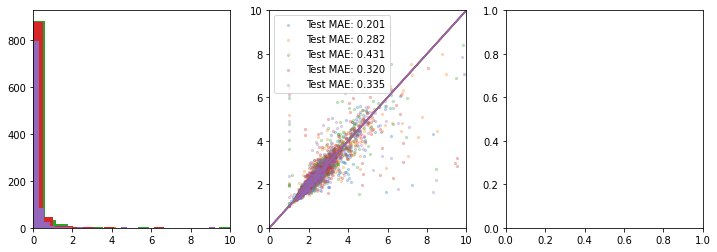

In [36]:
predictions, errors = plot_benchmark(results);